In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 测试代码
m = 100  # 样本数量
X = 2 * np.random.rand(m, 1)  

# 真实参数 a=4, b=3
true_theta = np.array([[4], [3]])

# 添加偏置项 x0 = 1
X = np.c_[np.ones((m, 1)), X] 

# 生成 y = 4 + 3x + 高斯噪声
y = X.dot(true_theta) + np.random.randn(m, 1)

# 将 X_b 和 y 组合起来，方便后续打乱
data = np.hstack([X, y])

# 损失函数是MSE对θ求导:X.T @ (θ @ X - y)

In [2]:
def train(algorithms,hyparams,X,y):
    true_theta = np.array([[4], [3]])
    initial_theta = np.random.randn(2, 1)

    theta_path = algorithms(X,y,initial_theta,hyparams)

    def compute_loss(theta, X, y):
        m = len(y)
        return (1/(2*m)) * np.sum((X.dot(theta) - y)**2)

    # 创建一个参数网格
    theta0_vals = np.linspace(0, 8, 100)
    theta1_vals = np.linspace(0, 6, 100)
    T0, T1 = np.meshgrid(theta0_vals, theta1_vals)
    J_vals = np.zeros(T0.shape)

    for i in range(T0.shape[0]):
        for j in range(T0.shape[1]):
            t = np.array([[T0[i, j]], [T1[i, j]]])
            J_vals[i, j] = compute_loss(t, X, y)

    plt.figure(figsize=(6, 4))
    # 绘制等高线
    contour = plt.contour(T0, T1, J_vals, levels=np.logspace(0, 3, 15), cmap=plt.cm.jet)
    plt.clabel(contour, inline=1, fontsize=10)
    plt.xlabel("b")
    plt.ylabel("w")

    # 绘制真实参数点
    plt.plot(true_theta[0], true_theta[1], 'r*', markersize=6, label="True θ(w and b)")
    plt.plot(theta_path[-1][0], theta_path[-1][1], 'o', markersize=6, label="final θ(w and b)")
    theta_path = np.array(theta_path)
    # 绘制路径
    plt.plot(theta_path[:, 0], theta_path[:, 1], 'g-s', markersize=2, linewidth=1, label=f"{algorithms.__name__}")

    plt.legend()
    plt.grid(True)
    plt.show()

    # 绘制损失随迭代次数的变化
    plt.figure(figsize=(6, 4))

    # 计算每一步的损失
    iter = hyparams['iterations']
    loss = [compute_loss(t, X, y) for t in theta_path]
    plt.plot(loss[:iter], 'g-', label=f"{algorithms.__name__}")
    plt.plot(iter-1,loss[-1], 'o', markersize=6, label="final loss")
    plt.xlabel("steps")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 10) 
    plt.show()  
    print("True θ:", true_theta.ravel())
    print("result:", theta_path[-1].ravel())
    print("loss:",loss[-1])

## 梯度下降

$$\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top.$$

可以对多变量函数使用相应的泰勒近似来思考:

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \mathbf{\boldsymbol{\epsilon}}^\top \nabla f(\mathbf{x}) + \mathcal{O}(\|\boldsymbol{\epsilon}\|^2).$$

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x}).$$

In [3]:
def gd(X,y,initial_theta,hyparams):
    theta = initial_theta
    theta_outputs = [theta]
    iterations = hyparams['iterations']
    lr = hyparams['lr']
    length = len(X)
    for i in range(iterations):
        gradient = X.T.dot(X.dot(theta)-y)/length
        theta = theta - lr*gradient
        theta_outputs.append(theta)
    return theta_outputs

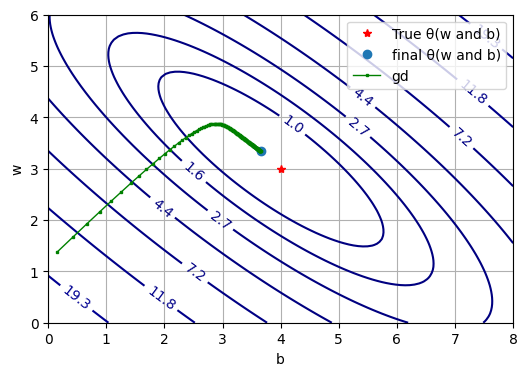

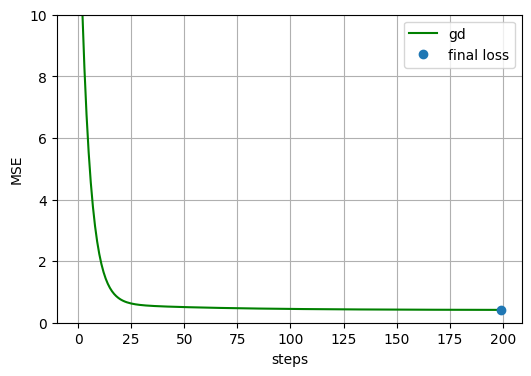

True θ: [4 3]
result: [3.65574355 3.33957278]
loss: 0.41676013375325655


In [4]:
train(gd,{'iterations':200,'lr':0.05},X,y)

## 随机梯度下降(sgd)

如果使用梯度下降法，则每个自变量迭代的计算代价为$\mathcal{O}(n)$，它随$n$线性增长。因此，当训练数据集较大时，每次迭代的梯度下降计算代价将较高。

随机梯度下降（SGD）可降低每次迭代时的计算代价。在随机梯度下降的每次迭代中，我们对数据样本随机均匀采样一个索引$i$，其中$i\in\{1,\ldots, n\}$，并计算梯度$\nabla f_i(\mathbf{x})$以更新$\mathbf{x}$：

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),$$

其中$\eta$是学习率。我们可以看到，每次迭代的计算代价从梯度下降的$\mathcal{O}(n)$降至常数$\mathcal{O}(1)$。此外，随机梯度$\nabla f_i(\mathbf{x})$是对完整梯度$\nabla f(\mathbf{x})$的无偏估计，因为

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$


In [5]:
def sgd(X,y,initial_theta,hyparams):
    theta = initial_theta
    theta_outputs = [theta]
    iterations = hyparams['iterations']
    lr = hyparams['lr']
    length = len(X)
    for i in range(iterations):
        random_int = np.random.randint(0, length)
        X_i = X[random_int:random_int+1]
        y_i = y[random_int:random_int+1]
        gradient = X_i.T.dot(X_i.dot(theta)-y_i)
        theta = theta - lr*gradient
        theta_outputs.append(theta)
    return theta_outputs

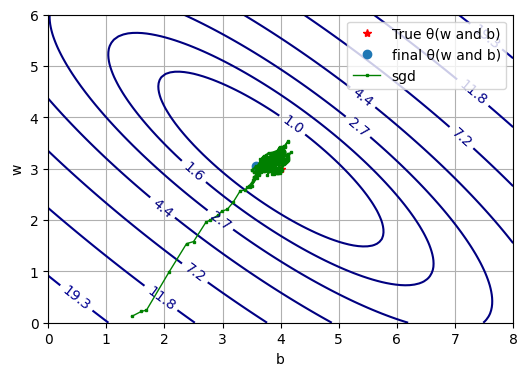

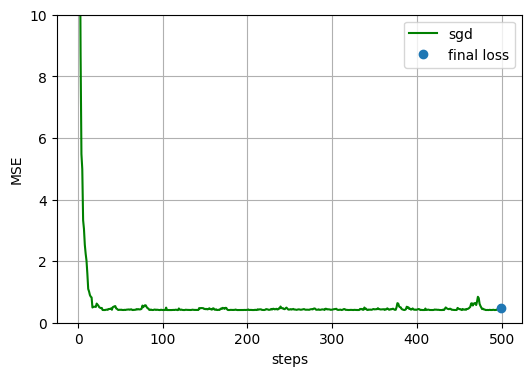

True θ: [4 3]
result: [3.57680788 3.05540393]
loss: 0.487726509440149


In [6]:
train(sgd,{'iterations':500,'lr':0.05},X,y)

In [7]:
def mini_batch_sgd(X,y,initial_theta,hyparams):
    theta = initial_theta
    theta_outputs = [theta]
    iterations = hyparams['iterations']
    lr = hyparams['lr']
    batch_size = hyparams['batch_size']
    length = len(X)
    for i in range(iterations):
         # 打乱数据
        shuffled_indices = np.random.permutation(m)
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]
        for j in range(0,length,batch_size):
            X_batch = X[j:j+batch_size]
            y_batch = y[j:j+batch_size]
            gradient = X_batch.T.dot(X_batch.dot(theta)-y_batch)/batch_size
            theta = theta - lr*gradient
            theta_outputs.append(theta)
    return theta_outputs

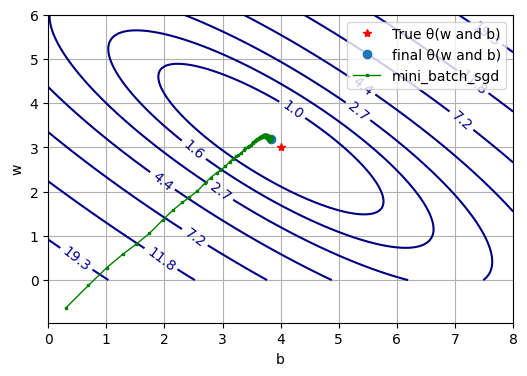

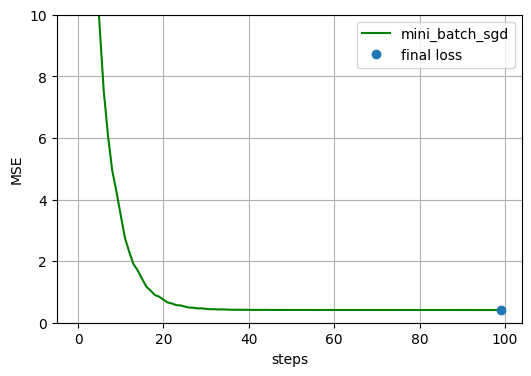

True θ: [4 3]
result: [3.83552681 3.18487617]
loss: 0.4115437812569209


In [8]:
train(mini_batch_sgd,{'iterations':100,'lr':0.05,'batch_size':20},X,y)

## 动量法
- 可以看作是对历史梯度的指数加权平均，越近的梯度权重越大
- 在动量法中，自变量在各个方向上的移动幅度不仅取决于当前梯度，还取决于过去的各个梯度在各个方向上是否一致

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}
$$

In [9]:
def momentum(X,y,initial_theta,hyparams):
    theta = initial_theta
    theta_outputs = [theta]
    iterations = hyparams['iterations']
    lr = hyparams['lr']
    length = len(X)
    vt = 0
    beta = hyparams['beta'] # 动量系数
    for i in range(iterations):
        vt = beta * vt + X.T.dot(X.dot(theta)-y)/length
        theta = theta - lr*vt
        theta_outputs.append(theta)
    return theta_outputs

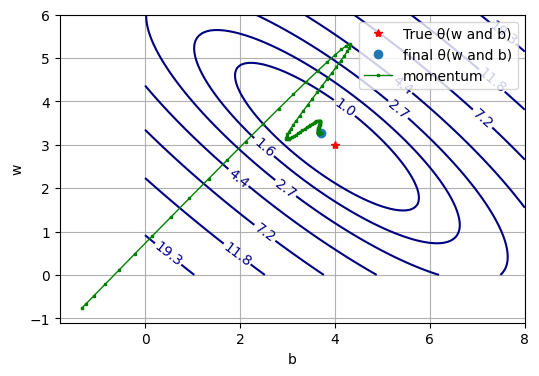

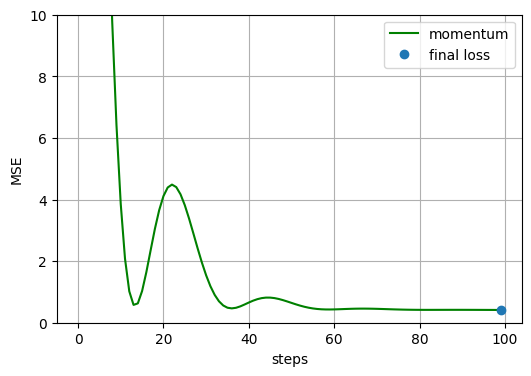

True θ: [4 3]
result: [3.70509229 3.27597196]
loss: 0.41409883183520313


In [10]:
train(momentum,{'iterations':100,'lr':0.01,'beta':0.9},X,y)

## AdaGrad

我们使用变量$\mathbf{s}_t$来累加过去的梯度方差，如下所示：

$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}$$

- 学习率一直在下降（或不变），最终可能难以收敛

In [11]:
def AdaGrad(X,y,initial_theta,hyparams):
    theta = initial_theta
    theta_outputs = [theta]
    iterations = hyparams['iterations']
    lr = hyparams['lr']
    length = len(X)
    st = np.zeros_like(theta)
    eps = 1e-6
    for i in range(iterations):
        gradient = X.T.dot(X.dot(theta)-y) / length
        st =st + gradient * gradient
        theta = theta - lr / np.sqrt(st + eps) * gradient
        theta_outputs.append(theta.copy())
    print("final lr:",lr / np.sqrt(st + eps))
    return theta_outputs

final lr: [[0.00996368]
 [0.00959327]]


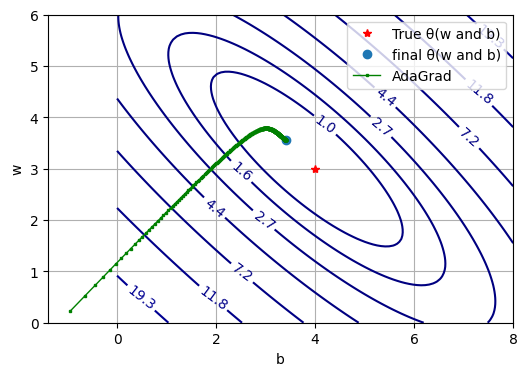

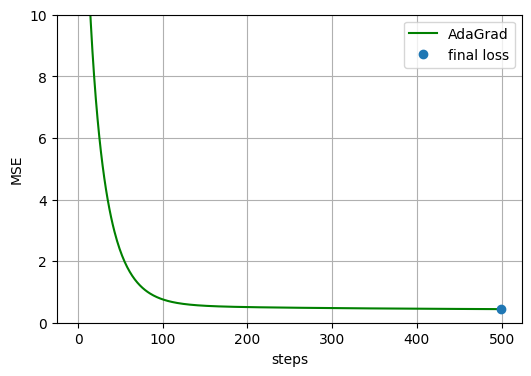

True θ: [4 3]
result: [3.41125635 3.55002053]
loss: 0.4412756797190421


In [12]:
train(AdaGrad,{'lr':0.3,'iterations':500},X,y)

## RMSProp
- 学习率不再一直降低（或不变）
$$\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}$$

In [13]:
def RMSProp(X,y,initial_theta,hyparams):
    theta = initial_theta
    theta_outputs = [theta]
    iterations = hyparams['iterations']
    lr = hyparams['lr']
    length = len(X)
    st = np.zeros_like(theta)
    eps = 1e-6
    eta = hyparams['eta']
    for i in range(iterations):
        gradient = X.T.dot(X.dot(theta)-y) / length
        st = eta * st + (1-eta) * gradient * gradient
        theta = theta - lr / np.sqrt(st + eps) * gradient
        theta_outputs.append(theta.copy())
    print("final lr:",lr / np.sqrt(st + eps))
    return theta_outputs

final lr: [[2.66427273]
 [2.65574513]]


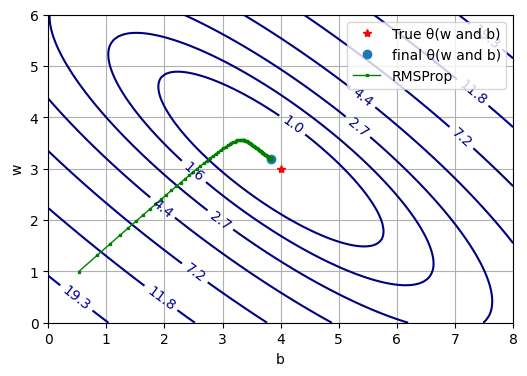

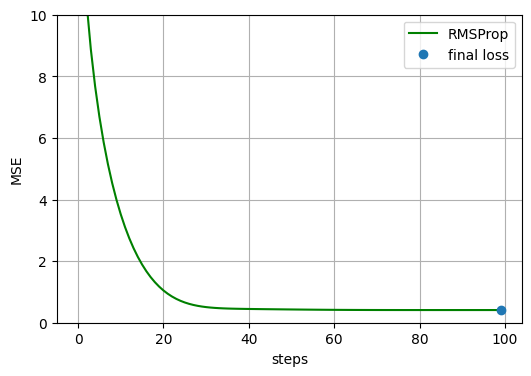

True θ: [4 3]
result: [3.83246277 3.18835603]
loss: 0.4115413078426811


In [14]:
train(RMSProp,{'lr':0.1,'iterations':100,'eta':0.9},X,y)

## AdaDelta

$$\begin{aligned}
    \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2.
\end{aligned}$$

调整后的梯度$\mathbf{g}_t'$是：

$$\begin{aligned}
    \mathbf{g}_t' & = \frac{\sqrt{\Delta\mathbf{x}_{t-1} + \epsilon}}{\sqrt{{\mathbf{s}_t + \epsilon}}} \odot \mathbf{g}_t, \\
\end{aligned}$$

与$ RMSProp $的区别在使用重新缩放的梯度$\mathbf{g}_t'$执行更新，即

$$\begin{aligned}
    \mathbf{x}_t  & = \mathbf{x}_{t-1} - \mathbf{g}_t'. \\
\end{aligned}$$

将$\Delta \mathbf{x}_{0}$初始化为$0$，然后在每个步骤中使用$\mathbf{g}_t'$更新它，即

$$\begin{aligned}
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) {\mathbf{g}_t'}^2,
\end{aligned}$$

$\epsilon$（例如$10^{-5}$这样的小值）是为了保持数字稳定性而加入的。

In [15]:
def AdaDelta(X,y,initial_theta,hyparams):
    theta = initial_theta
    theta_outputs = [theta]
    iterations = hyparams['iterations']
    length = len(X)
    st = np.zeros_like(theta)
    delta = np.zeros_like(theta)
    eps = 1e-6
    eta = hyparams['eta']
    for i in range(iterations):
        gradient = X.T.dot(X.dot(theta)-y) / length
        st = eta * st + (1-eta) * gradient * gradient
        g = np.sqrt((delta + eps)/(st + eps)) * gradient
        theta = theta - g
        delta = eta * delta + (1-eta) * g * g
        theta_outputs.append(theta.copy())
    return theta_outputs

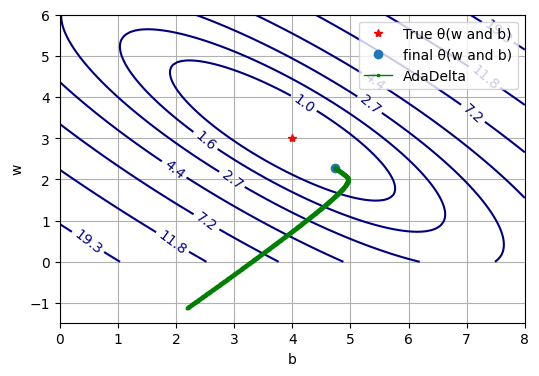

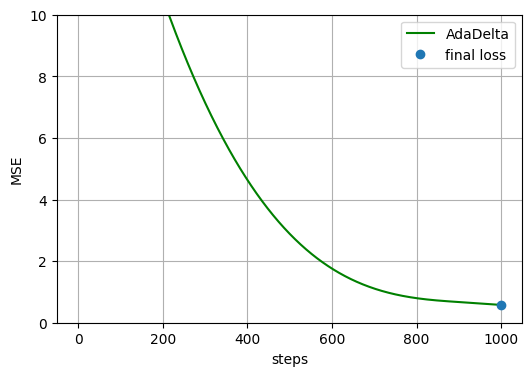

True θ: [4 3]
result: [4.72872551 2.2868081 ]
loss: 0.5774266268011453


In [16]:
train(AdaDelta,{'iterations':1000,'eta':0.95},X,y)

## Adam

$$\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2.
\end{aligned}$$

这里$\beta_1$和$\beta_2$是非负加权参数。
常将它们设置为$\beta_1 = 0.9$和$\beta_2 = 0.999$。
注意，如果初始化$\mathbf{v}_0 = \mathbf{s}_0 = 0$，就会获得一个相当大的初始偏差。
可以通过使用$\sum_{i=0}^t \beta^i = \frac{1 - \beta^t}{1 - \beta}$来解决这个问题。
相应地，标准化状态变量由下式获得

$$\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \text{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}.$$

首先以非常类似于RMSProp算法的方式重新缩放梯度以获得

$$\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.$$

与RMSProp不同，我们的更新使用动量$\hat{\mathbf{v}}_t$而不是梯度本身。
此外，由于使用$\frac{1}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$而不是$\frac{1}{\sqrt{\hat{\mathbf{s}}_t + \epsilon}}$进行缩放，两者会略有差异。
前者在实践中效果略好一些，因此与RMSProp算法有所区分。
通常，我们选择$\epsilon = 10^{-6}$，这是为了在数值稳定性和逼真度之间取得良好的平衡。

最后，我们简单更新：

$$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'.$$

In [17]:
def Adam(X,y,initial_theta,hyparams):
    theta = initial_theta
    theta_outputs = [theta]
    iterations = hyparams['iterations']
    lr = hyparams['lr']
    length = len(X)
    st = np.zeros_like(theta)
    vt = np.zeros_like(theta)
    momentum = hyparams['momentum']
    beta = hyparams['beta']
    eps = 1e-6
    for i in range(iterations):
        gradient = X.T.dot(X.dot(theta)-y) / length
        st = beta * st + (1-beta) * gradient * gradient
        vt = momentum * vt + (1-momentum) * gradient
        # 偏差纠正：使过去各时间步小批量随机梯度权值之和为1
        st = st / (1-beta**(i+1))
        vt = vt / (1-momentum**(i+1))
        theta = theta - lr / (np.sqrt(st)+eps) * vt
        theta_outputs.append(theta.copy())
    return theta_outputs

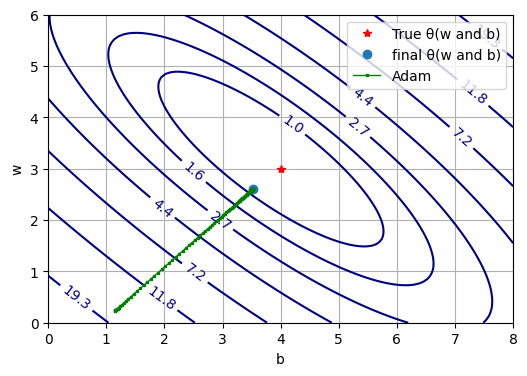

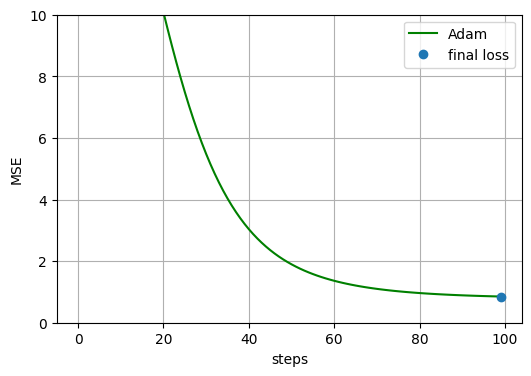

True θ: [4 3]
result: [3.52394282 2.60683066]
loss: 0.8473465500614354


In [18]:
train(Adam,{'lr':0.001,'beta':0.9,'momentum':0.9,'iterations':100},X,y)

## Yogi

Adam算法也存在一些问题：
即使在凸环境下，当$\mathbf{s}_t$的二次矩估计值爆炸时，它可能无法收敛。

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}).$$

论文中，作者还进一步建议用更大的初始批量来初始化动量，而不仅仅是初始的逐点估计。

In [19]:
def Yogi(X,y,initial_theta,hyparams):
    theta = initial_theta
    theta_outputs = [theta]
    iterations = hyparams['iterations']
    lr = hyparams['lr']
    length = len(X)
    st = np.zeros_like(theta)
    vt = np.zeros_like(theta)
    momentum = hyparams['momentum']
    beta = hyparams['beta']
    eps = 1e-6
    for i in range(iterations):
        gradient = X.T.dot(X.dot(theta)-y) / length
        st = beta * st + (1-beta) * np.square(gradient) * np.sign(np.square(gradient)-st)
        vt = momentum * vt + (1-momentum) * gradient
        # 偏差纠正：使过去各时间步小批量随机梯度权值之和为1
        st = st / (1-beta**(i+1))
        vt = vt / (1-momentum**(i+1))
        theta = theta - lr / (np.sqrt(st)+eps) * vt
        theta_outputs.append(theta.copy())
    return theta_outputs

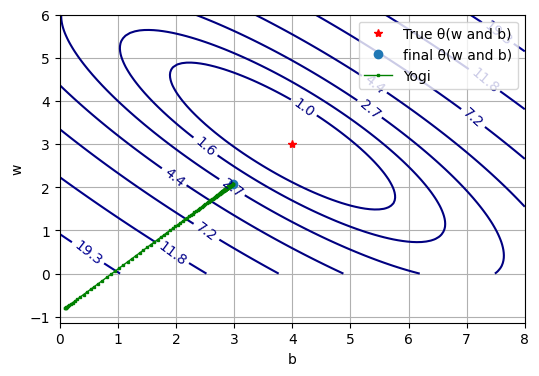

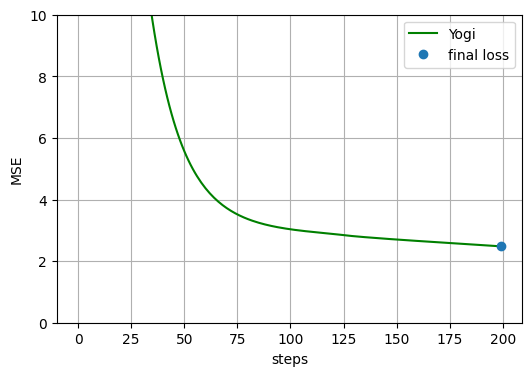

True θ: [4 3]
result: [2.97390553 2.07884778]
loss: 2.4757346292320266


In [20]:
train(Yogi,{'lr':0.001,'beta':0.9,'momentum':0.9,'iterations':200},X,y)

## 牛顿法

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \boldsymbol{\epsilon}^\top \nabla f(\mathbf{x}) + \frac{1}{2} \boldsymbol{\epsilon}^\top \nabla^2 f(\mathbf{x}) \boldsymbol{\epsilon} + \mathcal{O}(\|\boldsymbol{\epsilon}\|^3).$$

$$\nabla f(\mathbf{x}) + \mathbf{H} \boldsymbol{\epsilon} = 0 \text{ and hence }
\boldsymbol{\epsilon} = -\mathbf{H}^{-1} \nabla f(\mathbf{x}).$$

In [21]:
def newton(X, y, initial_theta, hyparams):
    theta = initial_theta.copy()
    theta_outputs = [theta.copy()]
    
    iterations = hyparams['iterations']
    m, _= X.shape 
    for i in range(iterations):
        gradient = X.T.dot(X.dot(theta) - y) / m
        # Hessian 矩阵: H = (1/m) * X^T X
        H = X.T.dot(X) / m
        # theta = theta - H⁻¹ @ gradient
        try:
            H_inv = np.linalg.inv(H)  # 求 Hessian 的逆
        except np.linalg.LinAlgError:
            H_inv = np.linalg.pinv(H)
        theta = theta - H_inv.dot(gradient)
        theta_outputs.append(theta.copy())  
    return theta_outputs

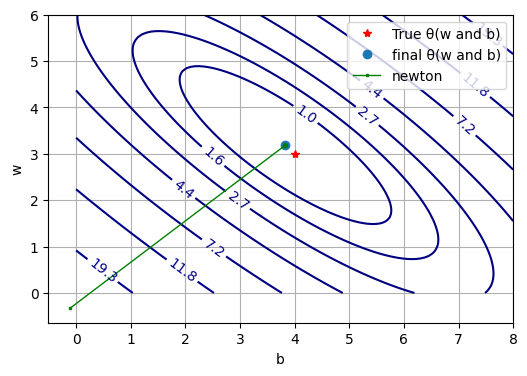

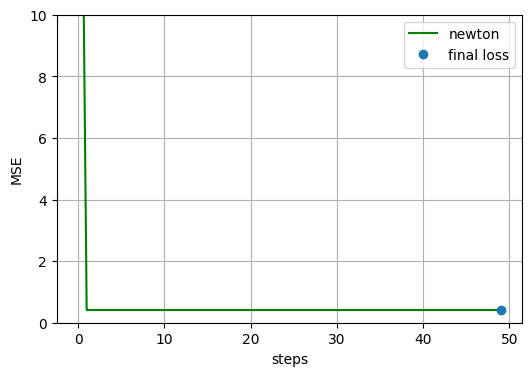

True θ: [4 3]
result: [3.83246805 3.18835153]
loss: 0.4115413078380309


In [22]:
train(newton,{'iterations':50},X,y)